# Klasifikassi Teks Word2Vec

In [1]:
_= !pip install jcopml
_= !pip install gensim
_= !pip instal tqdm
_= !pip instal nltk

In [2]:
import os
import pandas as pd #pandas
import numpy as np #numpy
from tqdm.auto import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stop_words = set(stopwords.words('indonesian'))

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/farisulhaq/dataset/main/pta_final.csv')

In [6]:
df

,stem,label
0,sistem informasi akademik siakad sistem inform...,rpl
1,berjalannya koneksi jaringan komput lancar gan...,rpl
2,web server perangkat lunak server berfungsimen...,rpl
3,seir perkembangan teknolog didunia muncul tekn...,komputasi
4,gerak pekerja game memiliki genr rt realtim st...,komputasi
...,...,...
591,investasi saham memiliki resiko kerugian dikar...,komputasi
592,inform retriev ir pengambilan informasi tersim...,pba
593,klasifikasi citra prose pengelompokan piksel c...,komputasi
594,identifikasi atribut pejalan kaki salah peneli...,komputasi


In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
sentences = [word_tokenize(kata) for kata in tqdm(df.stem)]

  0%|          | 0/596 [00:00<?, ?it/s]

## Train Word2Vec Model

In [9]:
model_word2vec = Word2Vec(sentences, vector_size=128, window=5, min_count=3, workers=4, sg=0, hs=0, epochs=1000)

### Save Word2Vec Model

In [10]:
folder = 'w2v/'
path = '/content/drive/MyDrive/prosaindata/prosaindata/' + folder 
os.makedirs(path, exist_ok=True)

In [11]:
model_word2vec.save(path+'text_klasifikasi.w2v')

## Encoding

In [12]:
from gensim.models import Word2Vec

In [13]:
w2v = Word2Vec.load(path+'text_klasifikasi.w2v').wv

In [14]:
def sent_vector(sentence, w2v_model, stopword):
  vecs = [w2v_model[kata.lower()] for kata in (sentence) if kata in w2v_model]
  sent_vec = np.mean(vecs, axis=0)
  return sent_vec

def norm_sent_vector(sentence, w2v_model, stopword):
  vecs = [w2v_model[kata.lower()] for kata in (sentence) if kata not in stopword]
  norm_vecs = [vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
  sent_vec = np.mean(norm_vecs, axis=0)
  return sent_vec

In [15]:
vecs = [sent_vector(kata, w2v, stop_words) for kata in sentences]
vecs = np.array(vecs)
vecs.shape

(596, 128)

## Dataset split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = vecs
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_test.shape

((476, 128), (120, 128))

## Training Model

In [19]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.feature_extraction.text import CountVectorizer

In [20]:
pipeline = Pipeline([
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(f'best_parameter: {model.best_params_}')
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_parameter: {'algo__C': 4.418441521199726, 'algo__gamma': 0.010547383621352041}
0.9873949579831933 0.8088235294117647 0.8083333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## Evaluasi

In [21]:
from jcopml.plot import plot_confusion_matrix

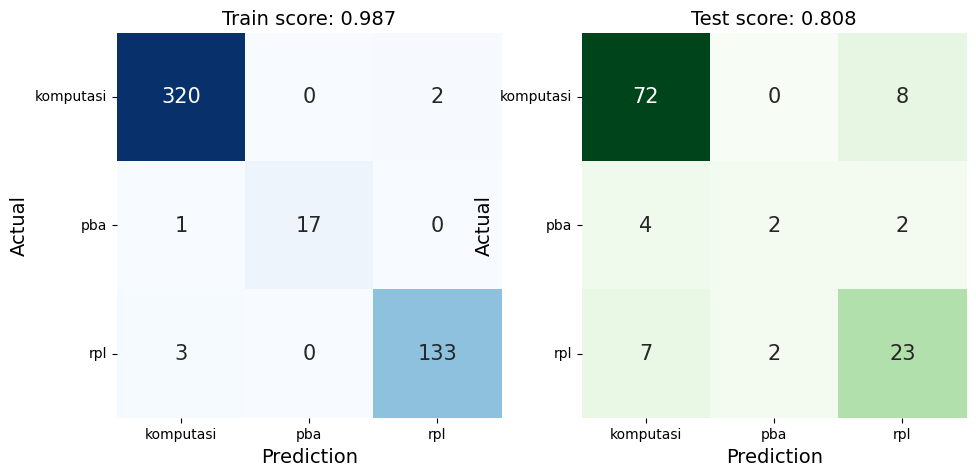

In [22]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)